In [1]:
# initial code 

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

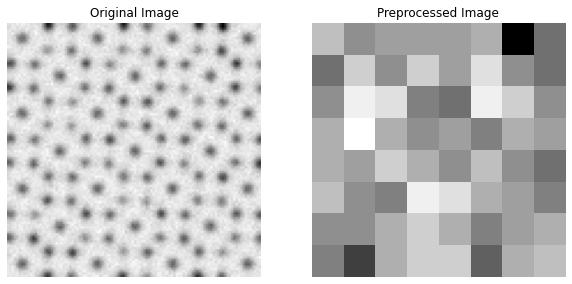

In [5]:
def preprocess_image(image_path, size=(8, 8)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

# Load and display the original image
image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e4dpa.png'  # Replace with your image path
original_img = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Preprocess the image
img_array = preprocess_image(image_path)

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

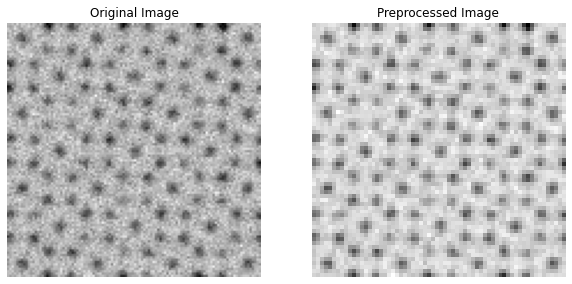

In [6]:
def preprocess_image(image_path, size=(64,64)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

# Load and display the original image
image_path = 'Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e3dpa.png'  # Replace with your image path
original_img = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Preprocess the image
img_array = preprocess_image(image_path)

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

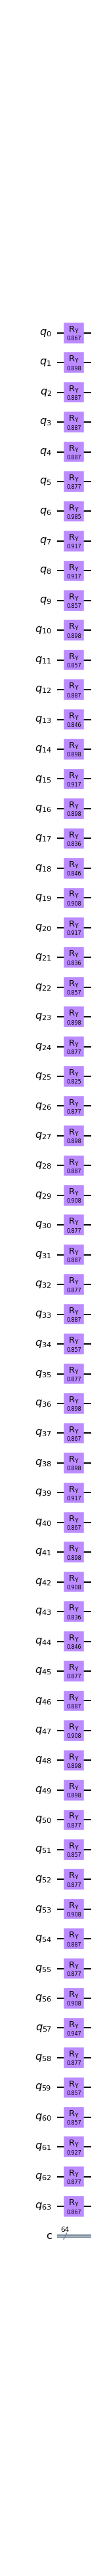

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = 64 #int(np.ceil(np.log2(size * size)))
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

# Encode the image into a quantum circuit
qc_image = encode_image(img_array)

# Draw the circuit for image encoding
circuit_image_encoding = circuit_drawer(qc_image, output='mpl', plot_barriers=False, justify='left')
circuit_image_encoding.savefig('quantum_image_encoding.png')

# Display the saved image
from IPython.display import Image
Image(filename='quantum_image_encoding.png')

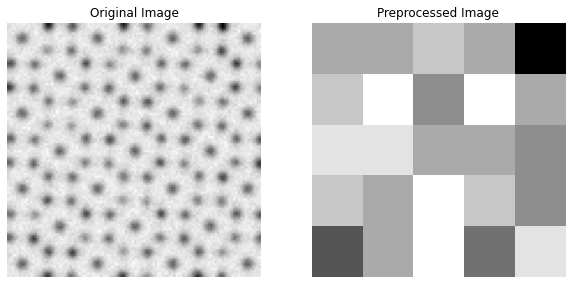

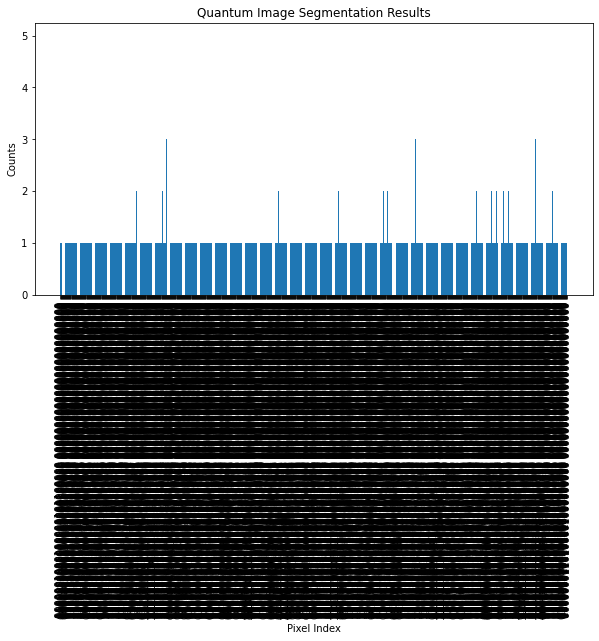

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.circuit.library import MCXGate

%matplotlib inline

def preprocess_image(image_path, size=(5,5)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()

    # Interpret the results
def interpret_results(counts, size):
    print("Counts:", counts)  # Debug: Print counts to see their format
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')  # Remove any spaces in the bitstring
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image


# Run the main function with the path to your image
main('Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e4dpa.png')  # Replace with your image path

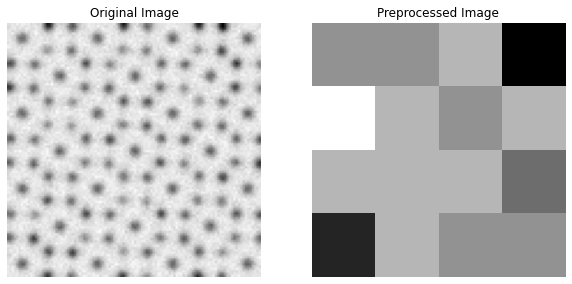

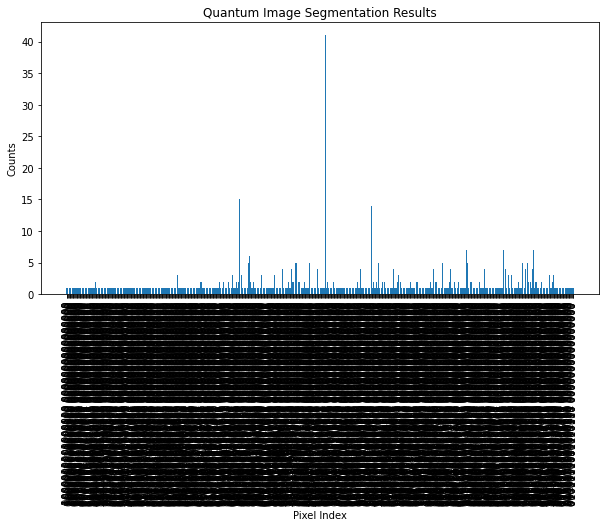

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.circuit.library import MCXGate

%matplotlib inline

def preprocess_image(image_path, size=(4,4)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()

    # Interpret the results
def interpret_results(counts, size):
    print("Counts:", counts)  # Debug: Print counts to see their format
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')  # Remove any spaces in the bitstring
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image


# Run the main function with the path to your image
main('Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e4dpa.png')  # Replace with your image path

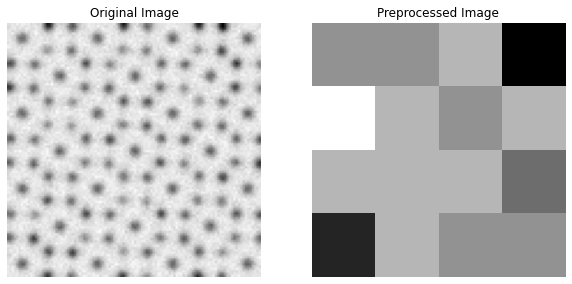

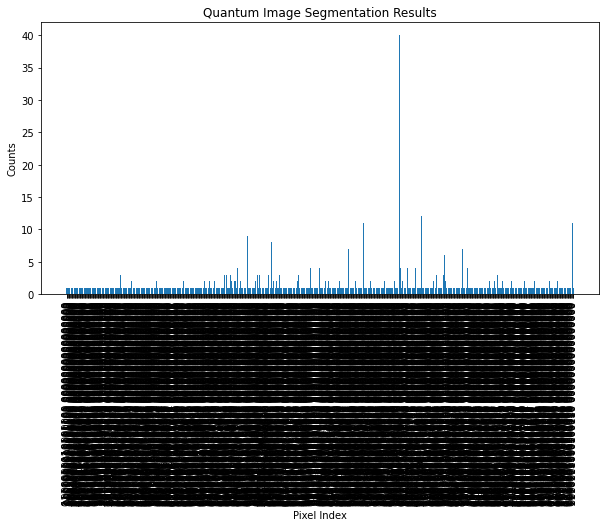

Counts: {'0110011010101100 0000000000000000': 1, '1000000110000000 0000000000000000': 1, '1101000011111101 0000000000000000': 1, '0000000000101001 0000000000000000': 1, '0000010000010000 0000000000000000': 1, '0001000000001100 0000000000000000': 1, '1011000110011100 0000000000000000': 1, '1011110101101101 0000000000000000': 1, '0101010010000000 0000000000000000': 1, '0000000010100100 0000000000000000': 1, '1001100101101010 0000000000000000': 1, '0001000001100010 0000000000000000': 1, '0000010001000010 0000000000000000': 1, '0000000010010100 0000000000000000': 1, '1110011111101101 0000000000000000': 1, '0000000010011001 0000000000000000': 1, '1101101011001100 0000000000000000': 1, '0000000110100100 0000000000000000': 1, '0100011001000000 0000000000000000': 1, '1000010000000010 0000000000000000': 1, '1000010010010000 0000000000000000': 1, '0100000001110000 0000000000000000': 1, '0010100000011010 0000000000000000': 1, '0000011000001000 0000000000000000': 1, '1010101110111110 0000000000000

/home/iim2209/abtem-env/lib64/python3.6/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in true_divide
/home/iim2209/abtem-env/lib64/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/iim2209/abtem-env/lib64/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/iim2209/abtem-env/lib64/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


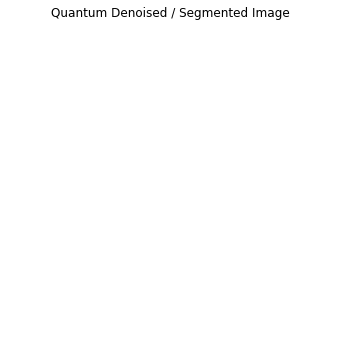

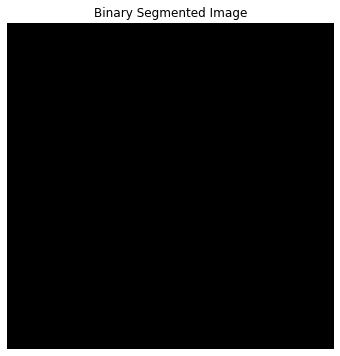

In [10]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.circuit.library import MCXGate

%matplotlib inline

def preprocess_image(image_path, size=(4, 4)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()
    
    # Interpret and visualize segmentation results
    segmented = interpret_results(counts, size=img_array.shape[0])

    plt.figure(figsize=(6, 6))
    plt.imshow(segmented, cmap='gray')
    plt.title("Quantum Denoised / Segmented Image")
    plt.axis('off')
    plt.show()

    # Optional: Binary segmentation visualization
    binary_segmented = (segmented > 0.5).astype(np.uint8)

    plt.figure(figsize=(6, 6))
    plt.imshow(binary_segmented, cmap='gray')
    plt.title("Binary Segmented Image")
    plt.axis('off')
    plt.show()

    # Interpret the results
def interpret_results(counts, size):
    print("Counts:", counts)  # Debug: Print counts to see their format
    n_qubits = size * size
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')[::-1]  # Remove any spaces in the bitstring.
        #QiSkit orders qubits backwards
        for i in range(n_qubits):
            if bitstring[i] =='1':
                row = i // size
                col = i % size
                segmented_image[row, col] += count # accumulate counts per pixel
    #normalize to [0,1]
    segmented_image = segmented_image / segmented_image.max()
    return segmented_image


# Run the main function with the path to your image
main('Images/Ir-KMnO2_62025_noise/resized_bf_image_Ir20pc_1e4dpa.png')  # Replace with your image path